
--- Classification Report ---
                                                    precision    recall  f1-score   support

                                 Apple__Apple_scab     0.2000    0.5000    0.2857         4
                                  Apple__Black_rot     0.0000    0.0000    0.0000         5
                           Apple__Cedar_apple_rust     0.0000    0.0000    0.0000         4
                                    Apple__healthy     0.3333    0.7500    0.4615         4
                               Blueberry___healthy     0.2500    1.0000    0.4000         1
          Cherry_(including_sour)___Powdery_mildew     1.0000    0.5000    0.6667         4
                 Cherry_(including_sour)___healthy     0.0000    0.0000    0.0000         4
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     0.3636    1.0000    0.5333         4
                       Corn_(maize)___Common_rust_     0.0000    0.0000    0.0000         4
               Corn_(maize)___Northern_Leaf_Blig

c:\Users\Emircan\anaconda3\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Emircan\anaconda3\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Emircan\anaconda3\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


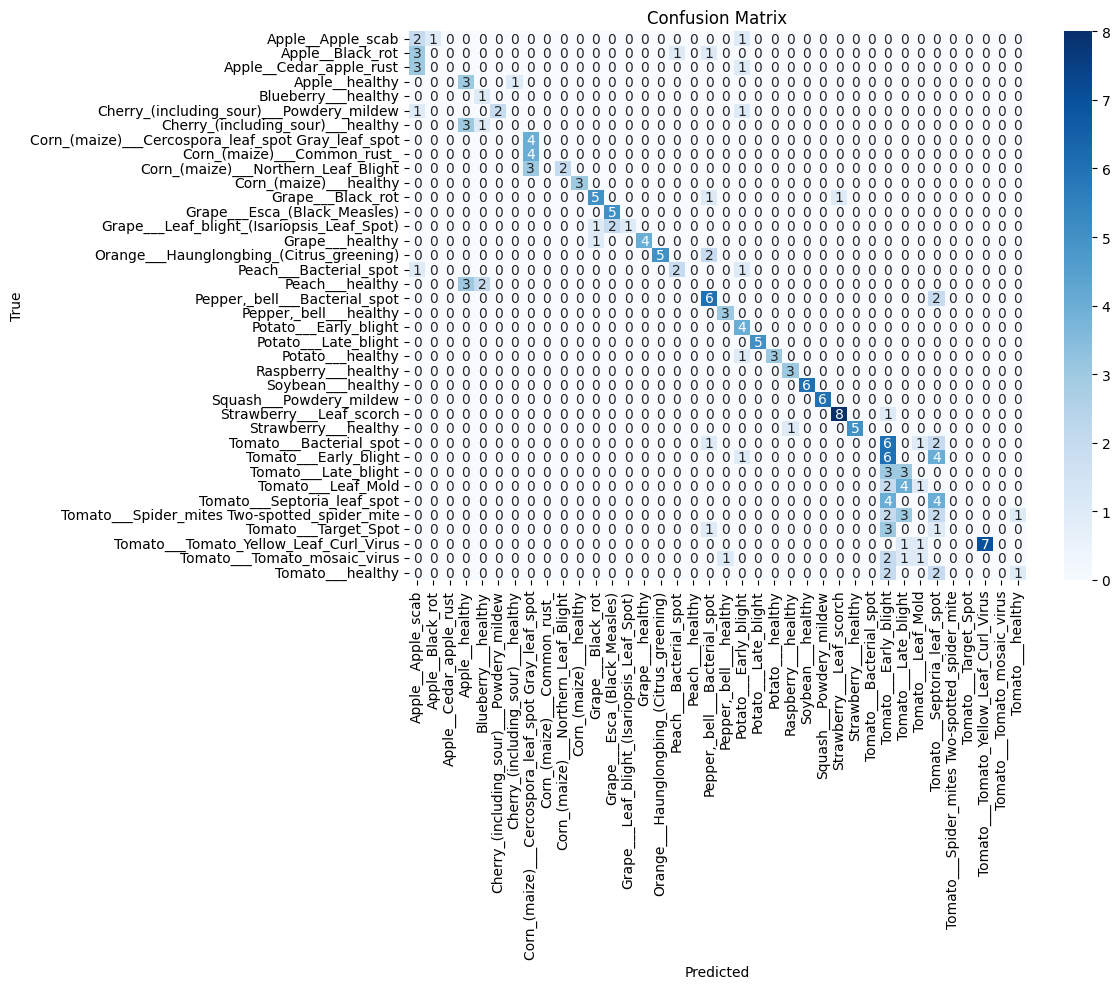

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from transformers import Dinov2Model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === 1. Config ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 38
batch_size = 8

test_data_path = r"D:\PlantMaster\Dataset\test3"
model_path = r"D:\PlantMaster\PlantMaster_Model\modeller\dinov2\dinov2_best.pth"  # ← kendi model path'inizi buraya girin

# === 2. Dönüştürme (transform) ve Test Seti Yükleme ===
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(test_data_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
class_names = test_dataset.classes

# === 3. Model Tanımı ===
class DINOv2Classifier(nn.Module):
    def __init__(self, num_classes=38):
        super().__init__()
        self.dinov2 = Dinov2Model.from_pretrained("facebook/dinov2-base")
        self.classifier = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        features = self.dinov2(x).last_hidden_state
        pooled = features.mean(dim=1)
        return self.classifier(pooled)

# === 4. Model Yükleme ===
model = DINOv2Classifier(num_classes=num_classes).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# === 5. Test ve Skor Hesaplama ===
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# === 6. Sınıflara Göre Rapor ===
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("\n--- Classification Report ---")
print(report)

# === 7. Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix_dinov2.png")
plt.show()
